# Sea ice seasonality statistics: an example in the Southern Ocean

This notebook calculates number of days of sea ice advance, retreat, and sea ice duration over the sea ice season (February 15 to February 14) in the Southern Ocean using outputs from ACCESS-OM2-01.  

### Loading relevant modules

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import datetime as dt
from dask.distributed import Client
import cmocean.cm as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import matplotlib.path as mpath

Start a dask client:

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41345 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41345/status,
Dashboard: /proxy/41345/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46185,Workers: 7
Dashboard: /proxy/41345/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42459,Total threads: 1
Dashboard: /proxy/36221/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35699,


### Load sea ice concentration

COSIMA Cookbook session to access databases, and experiment to load:

In [3]:
catalog = intake.cat.access_nri

exp = "01deg_jra55v140_iaf_cycle2"

expt_datastore = catalog[exp]

# Southern Ocean domain only:
lat_slice = slice(-80, -50)

Setting date range for the analysis. Note that because times linked to `CICE` outputs require a correction, we need to start by loading a wider time window than we actually analyse. In this recipe, we use just a single year for illustration purposes.


In [4]:
# Sea ice year is between Feb 15 to Feb 14 (sea ice year), but we need to open until March until we do time corrections below:
year = 2000
start_time = f"{year}-02"
end_time = f"{year+1}-03"

### Notes for accessing CICE outputs: 
- We need to apply a **time correction**, because midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time coordinate.  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  

In [5]:
concentration = expt_datastore.search(
    variable="aice",start_date="200[0,1].*"
).to_dask(xarray_open_kwargs = {
    # "chunks": "auto", 
    "use_cftime" : True,
    "decode_coords": False,
    "decode_timedelta" : False,
})['aice'].sel(time=slice(start_time,end_time))


# Applying time correction 
concentration['time'] = concentration.time - dt.timedelta(hours = 12)

# Overwrite coordinates used by CICE output:
# Loading geographical coordinates in a more useful format:
geolon_t = expt_datastore.search(variable="geolon_t").to_dask()
# overwrite coords:
concentration.coords['ni'] = geolon_t['xt_ocean'].values
concentration.coords['nj'] = geolon_t['yt_ocean'].values

# Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
concentration = concentration.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))

# Subsetting data to area of interest
concentration = concentration.sel(yt_ocean = lat_slice)

# Selecting data between Feb 15 to Feb 14 (sea ice year)
concentration = concentration.sel(time = slice(start_time + '-15', str(year + 1) + '-02-14'))

### Sea ice seasonality calculations
This code calculates annual sea ice advance, retreat and total sea ice season duration as defined by Massom et al 2013 [DOI:10.1371/journal.pone.0064756].  

If sea ice concentration in any grid cell is at least 15% over five consecutive days, sea ice is considered to be *advancing*. 

Sea ice is defined to be *retreating* when its concentration is below 15% in any pixel until the end of the sea ice year. 

Sea ice *season duration* is the period between day of advance and retreat. 

The sea ice year is defined to be between February 15 and February 14 the following year.

In [6]:
# threshold refers to the minimum sea ice concentration threshold. The default is set to 0.15:
min_threshold = 0.15

# Calculate total number of days in year (365 or 366 depending on whether it is a leap year or not):
days_in_year = len(concentration.time.values)

# Identify grid cells where sea ice concentration values are equal or above min_threshold.
# Resulting data array is boolean. If concentration > 0.15, then set to True, otherwise set to False:
conc_above_threshold = xr.where(concentration >= min_threshold, True, False)

# Add values through time to get total number of days with ice cover of at least 15% within a grid cell:
days_above_threshold = conc_above_threshold.sum('time').compute()

Set up some things for nice stereographic plots:

In [7]:
# Create a circular path to clip plots:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# get land:
ht = expt_datastore.search(variable="ht").to_dask()['ht'].sel(yt_ocean=lat_slice).load()
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
# Adjust latitude on land, so it goes to south pole. Needed for prettier plotting:
land_lat = land.yt_ocean.values
land_lat[0] = -90
land['yt_ocean'] = land_lat

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


Plot days_above_threshold:

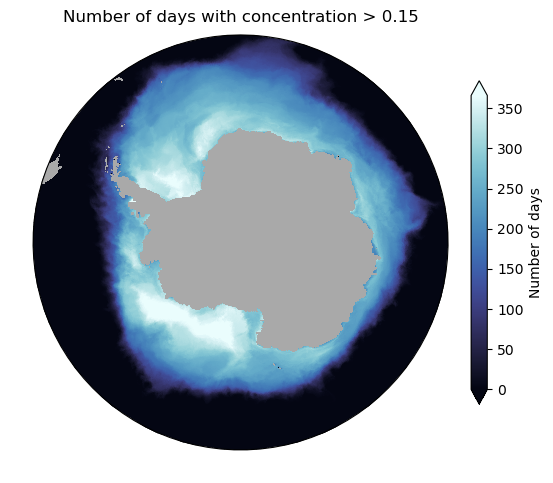

In [8]:
fig = plt.figure(1, figsize=(7, 7))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax,
                   colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

days_above_threshold.plot(ax=ax,
                          cmap=cm.ice,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs={'orientation': 'vertical',
                                       'shrink': 0.6,
                                       'extend': 'both',
                                       'label': 'Number of days',
                                       'aspect': 20,
                                       'pad': 0})

ax.set_title('Number of days with concentration > 0.15' , y=0.96);

Create boolean data arrays for masking:

In [9]:
# If the days_above_threshold is zero, then set grid cell to be True, otherwise set to False. 
# This identifies grid cells where minimum sea ice concentration was never reached.
noIce = xr.where(days_above_threshold == 0, True, False)

# min_days_threshold is the minimum number of consecutive days that sea ice must be above min_threshold 
# to be classified as advancing. Default set to 5:
min_days_threshold = 5

# If the days_above_threshold is less than min_days_threshold, then set grid cell to be True, otherwise set to False. 
# This identifies grid cells where sea ice coverage did not meet the minimum consecutive days requirement.
noIceAdvance = xr.where(days_above_threshold < min_days_threshold, True, False)

# If the days_above_threshold is the same as days_in_year, then set grid cell to be True, otherwise set to False.
# This identifies grid cells where sea ice concentration was always at least 15%
alwaysIce = xr.where(days_above_threshold == days_in_year, True, False)

### Sea ice advance calculations

In [10]:
# Use cumulative sums based on time. If grid cell has sea ice cover below min_threshold, then cumulative sum is reset to zero:
advance = conc_above_threshold.cumsum(dim = 'time') - conc_above_threshold.cumsum(dim = 'time').where(conc_above_threshold.values == 0).ffill(dim = 'time').fillna(0)
# Note: ffill adds nan values forward over a specific dimension

# Find time index where the minimum consecutive sea ice concentration was first detected for each grid cell
# Change all grid cells that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
advanceDate = xr.where(advance == min_days_threshold, advance, False)

# Find the time index where condition above was met:
advanceDate = advanceDate.argmax(dim = 'time')

# Apply masks of no sea ice advance (noIceAdvance) and sea ice always present (alwaysIce).
advanceDate = advanceDate.where(noIceAdvance == False, np.nan).where(alwaysIce == False, 1).compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 810.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Plot day of year of sea ice advance. Note that this is defined relative to February 15th.

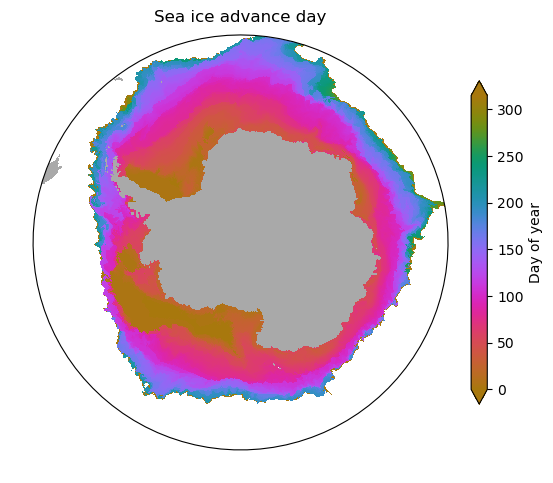

In [11]:
fig = plt.figure(1, figsize=(7, 7))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax,
                   colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

advanceDate.plot(ax=ax,
                 cmap=cm.phase,
                 transform=ccrs.PlateCarree(),
                 cbar_kwargs={'orientation': 'vertical',
                              'shrink': 0.6,
                              'extend': 'both',
                              'label': 'Day of year',
                              'aspect': 20,
                              'pad': 0})

ax.set_title('Sea ice advance day' , y=0.96);

### Sea ice retreat calculations

In [12]:
# Reverse conc_above_threshold in time dimension, so end date is now the start date and calculate cumulative sum over time:
retreat = conc_above_threshold[::-1].cumsum('time')

# Change zero values to 9999 so they are ignored in the next step of our calculation:
retreat = xr.where(retreat == 0, 9999, retreat)

# Find the time index where sea ice concentration changes to above threshold:
retreatDate = retreat.argmin(dim = 'time')

# Substract index from total time length:
retreatDate = days_in_year - retreatDate

# Apply masks of no sea ice over min_threshold (noIce) and sea ice always present (alwaysIce):
retreatDate = retreatDate.where(noIce == False, np.nan).where(alwaysIce == False, days_in_year).compute()

Plot day of year of sea ice retreat. Note that this is defined relative to February 15th.

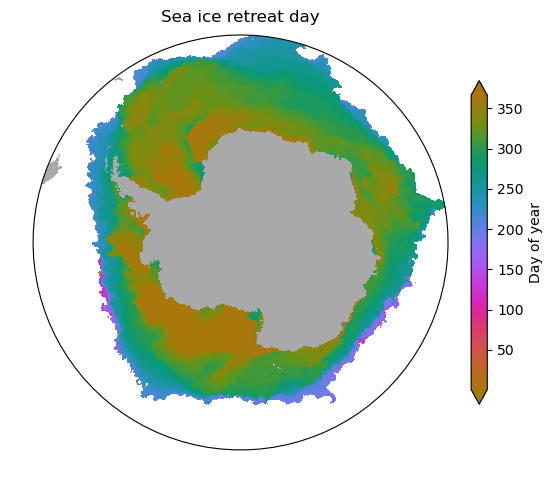

In [13]:
fig = plt.figure(1, figsize=(7, 7))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

retreatDate.plot(ax = ax, cmap=cm.phase,
                                         transform=ccrs.PlateCarree(),
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.6,
                                                      'extend': 'both',
                                                      'label': 'Day of year',
                                                      'aspect': 20,
                                                      'pad': 0})

ax.set_title('Sea ice retreat day' , y=.96);

### Sea ice duration

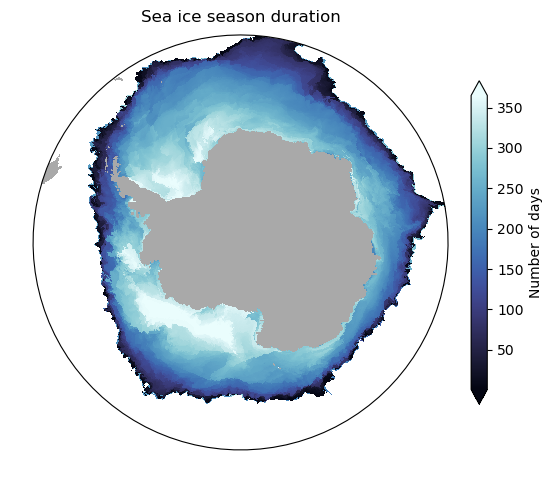

In [14]:
durationDays = retreatDate - advanceDate

fig = plt.figure(1, figsize=(7, 7))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax,
                   colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

durationDays.plot(ax=ax,
                  cmap=cm.ice,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={'orientation': 'vertical',
                               'shrink': 0.6,
                               'extend': 'both',
                               'label': 'Number of days',
                               'aspect': 20,
                               'pad': 0})

ax.set_title('Sea ice season duration', y=0.96);

In [15]:
client.close()